<a href="https://colab.research.google.com/github/capofwesh20/Face_ID/blob/main/Project_Face_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Building a Facial Identity Recognition System

Steps taken:

* finding pretrained image embedding models and using them on our own data 👾
* building an image dataset and uploading it to the Hugging Face Hub 📖
* measuring the performance of an image embedding model on test data and the real world 📈
* building a facial identity recognition app you can run on your phone or laptop 📷


# Introduction

[Face ID](https://en.wikipedia.org/wiki/Face_ID) was introduced by Apple in 2017 as an alternative to fingerprint-based authentication for iPhones. The way that Face ID works is that it uses infrared projectors that shine around 30,000 infrared dots onto a user's face. Then an infrared camera reads the reflections to come up with an infrared "image" of a person's face. Using neural networks, Face ID predicts if the recorded infrared image is similar enough to a stored profile, in which case the phone unlocks.

In this project, we will recreate the last part of this process -- building an application that can recognize if two faces belong to the same person, based on optical pictures (i.e. regular images, not infrared images) of their face. This is quite a difficult problem because it requires us to simultaneously perform two tasks: (1) tell two people (who may look quite similar) apart (2) recognize that two photos of the same person (potentially taken in very different lighting, clothing, or other conditions) are of the same person. In order to do this project, we will use models for *image embedding*, which can convert any image to a numerical vector called an embedding. These embeddings can be used to compare images more easily, as computing distances between different embeddings can be a meaningful signal of how similar the respective images are.

By the end of this project, you'll have built an app that takes in two pictures from your webcam and will predict whether they are the same person or not. This can form the basis of facial identity recognition software. It will look something like this:

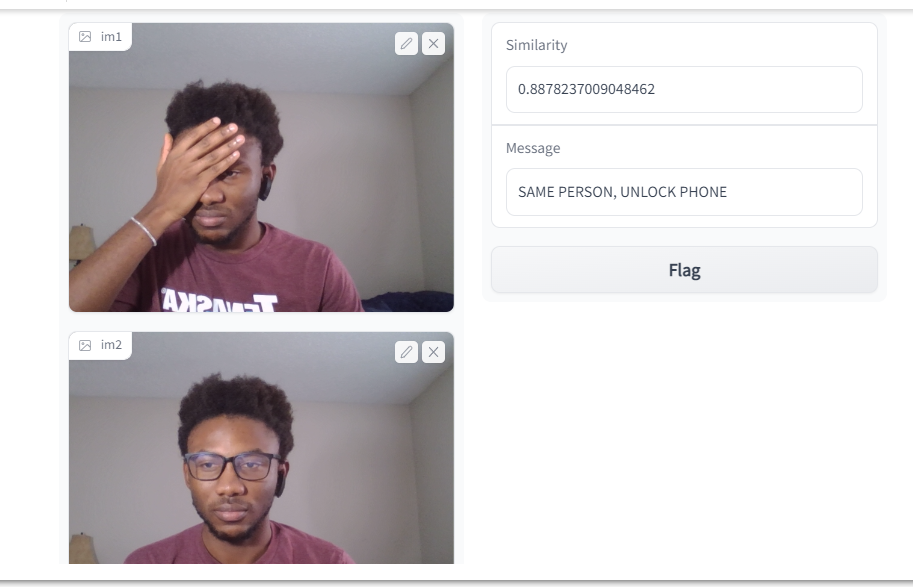

# Step 0: Hardware Setup & Software Libraries

We will be utilizing GPUs to train our machine learning model, so we will need to make sure that our colab notebook is set up correctly. Go to the menu bar and click on Runtime > Change runtime type > Hardware accelerator and **make sure it is set to GPU**. Your colab notebook may restart once you make the change.

We're going to be using some fantastic open-source Python libraries to upload our dataset (`datasets`), load our model (`sentence-transformers`), evaluate our model (`scikit-learn`), and build a demo of our model (`gradio`). So let's go ahead and install all of these libraries. 

In [ ]:
!pip install datasets huggingface_hub sentence-transformers gradio 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In Week 2, you uploaded a model to your Hugging Face account programmatically. This week, you'll be uploading a dataset! The first step is to log in using your Hugging Face token:

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


# Step 1: Loading Pretrained Image Embedding Models

In this project, we will be loading several pretrained image embedding models and comparing their performance. In particular, we will compare:

* https://huggingface.co/sentence-transformers/clip-ViT-B-16
* https://huggingface.co/sentence-transformers/clip-ViT-B-32
* https://huggingface.co/sentence-transformers/clip-ViT-L-14

* **1a. Compare the models**

When considering which machine learning model to use for a particular task, there are several things to consider:
* The metrics that are relevant to you
* The size of the model
* The inference time of the model

Which of these models has the best reported performance on the model card? Which has the worst reported performance? 
1. The best Reported performance is clip-ViT-L-14 with 75.4% on the ImageNet validation set.
2. The worst reported performance is clip-ViT-B-32 with 63.3%


What task was the performance reported on? What does this task mean?
1. Zero shot evaluation (Image that the model has not seen before)


Which of these models has the the largest size on disk? Which is the smallest? *Hint*: look for the PyTorch binary file. 
1. clip-ViT-L-14 has the largest size
2. clip-ViT-B-32 is smallest


What model do you expect to run the fastest? The slowest? [ANSWER HERE]

1. clip-ViT-L-14 will run the fastest
2. clip-ViT-B-32 the slowest

* **1b. Load one of the models**

Pick one of the three models above and load it using the [Sentence Transformers](https://www.sbert.net/) library.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('clip-ViT-B-16')

* **1c. Use the model to embed a few photos with faces**

The following code downloads and displays 3 images from the web. We will use the `SentenceTransformer` you downloaded above to embed these images.

Robert Downey Jr


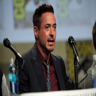

Robert Downey Jr


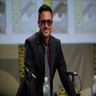

Gwyneth Paltrow


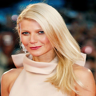

Andrew Ng


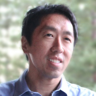

In [ ]:
from PIL import Image
from io import BytesIO
import requests

urls = {
    "https://live.staticflickr.com/5551/14616229927_7ed70f7836_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/3849/14800476884_6dbda11c8c_b.jpg": "Robert Downey Jr",
    "https://live.staticflickr.com/8187/8138909428_2d9e94332a.jpg": "Gwyneth Paltrow",
    "https://pbs.twimg.com/profile_images/733174243714682880/oyG30NEH_400x400.jpg": "Andrew Ng"
}

image_list = []

for index, (url, label) in enumerate(urls.items()):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  image_list.append(img)
  print(label)
  display(img.resize((96,96)))

Use the `SentenceTransformer` model to embed these images.

In [ ]:
img_emb = model.encode(image_list)

* **1d. Explore the embeddings**

* What are the dimensions of the images we downloaded? 

In [ ]:
images_dimension = []
for images in image_list:
  width, height = images.size
  images_dimension.append((width, height))
images_dimension

[(1024, 683), (1024, 683), (405, 480), (398, 398)]

* What is the dimensionality of the embedding for each image?


In [ ]:
img_emb[0].shape

(512,)

No matter the size of the images, it outputs 512



* Do the dimensions of the images affect the dimensionality of the embedding? 

Not at all, burt will differ if I pick another model

* Finally, let's compare how similar the image embeddings are to each other. We will use [*cosine similarity*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html), the metric we discussed in lecture to compare image similarity.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(img_emb)

array([[0.9999999 , 0.9432374 , 0.5146092 , 0.5211674 ],
       [0.9432374 , 1.        , 0.50051796, 0.47618353],
       [0.5146092 , 0.50051796, 0.99999976, 0.41713282],
       [0.5211674 , 0.47618353, 0.41713282, 1.0000001 ]], dtype=float32)

According to the embedding model:
* What is the cosine similarity between image 1 and image 2? 0.9432374, very similar 
* What is the cosine similarity between image 1 and image 3? 0.5146092 

Is this what you expected? Yes

# Step 2: Finding and Uploading a Dataset

In order to test our embedding models more systematically, we'll need an entire dataset, not just a few samples. For this assignment, you will build your OWN dataset by downloading images of celebrities' faces. The purpose of this step is to think about how to build a representative dataset

Here are some things to consider as you build your own dataset:

* Dataset diversity: choose **at least 6 different celebrities** (Can you choose celebrities of different ages, ethnicities, genders? What other considerations are important here?) 
* Dataset size: Since we are not training an image embedding model from scratch, but simply evaluating different models, we will not require a particularly large dataset. Please have **at least 3 images per celebrity** (so your total dataset size should be at least 18 images.)
* Dataset consistency: all of the images in the dataset should consist primarily of **celebrity faces** only
* Dataset balance: you may want to have a dataset that is relatively balanced among the different celebrities
* Dataset license: you should make sure to use images under a permissive license, such as Creative Commons.

We suggest using either [Openverse](https://wordpress.org/openverse/) or [Flickr](https://flickr.com/) to easily find images that are under a Creative Commons license. 

First, create a dictionary, whose keys are image URLs and whose labels are the name of the celebrity (similar to the `urls` dictionary in step 1b):

In [ ]:
urls = {
    #1 Roger Federer
    'https://live.staticflickr.com/8489/8211308754_6123810725_m.jpg': 'Roger Federer',
    'https://live.staticflickr.com/1254/1353139840_6b18d95205_n.jpg' : 'Roger Federer',
    'https://live.staticflickr.com/4151/4958541472_4022fd488a_n.jpg': 'Roger Federer',

    #2 Serena Williams
    'https://live.staticflickr.com/65535/50347189461_f6d7e4ba23_n.jpg' : 'Serena Williams',
    'https://live.staticflickr.com/7577/29662668656_a84b78ba3a_m.jpg' : 'Serena Williams',
    'https://live.staticflickr.com/303/32188721620_7fb541ee19_w.jpg' : 'Serena Williams',

    #3 Peter Obi
    'https://live.staticflickr.com/1908/30346450097_556270078e_w.jpg' : 'Peter Obi',
    'https://live.staticflickr.com/1782/42180531095_3a841af436_n.jpg' : 'Peter Obi',
    'https://live.staticflickr.com/7841/33697283668_a3fdb26ac3_w.jpg' : 'Peter Obi',

    #4 Cristiano Ronaldo
    'https://live.staticflickr.com/2832/9411007877_d311798b4b_w.jpg' : 'Cristiano Ronaldo',
    'https://live.staticflickr.com/8824/18354213386_d0290e1cf8_w.jpg' : 'Cristiano Ronaldo',
    'https://live.staticflickr.com/65535/51451113145_efa5c91e6e_m.jpg' : 'Cristiano Ronaldo',

    #5 Nicki Minaj
    'https://live.staticflickr.com/4215/35525999760_687228402c_n.jpg' : 'Nicki Minaj',
    'https://live.staticflickr.com/3946/33364250381_3cea2dde0a_n.jpg' : 'Nicki Minaj',
    'https://live.staticflickr.com/651/32675222646_6d6b998576_m.jpg' : 'Nicki Minaj',

    #6. Jay Z
    'https://live.staticflickr.com/65535/49026881478_c5eaa09b94_w.jpg': 'Jay Z',
    'https://live.staticflickr.com/4258/34874532070_3ef7d5ef69_n.jpg': 'Jay Z',
    'https://live.staticflickr.com/1342/5140895154_6dc66253d5_m.jpg' : 'Jay Z'
}

Then, run the following code to download the images and save them into organized folders:

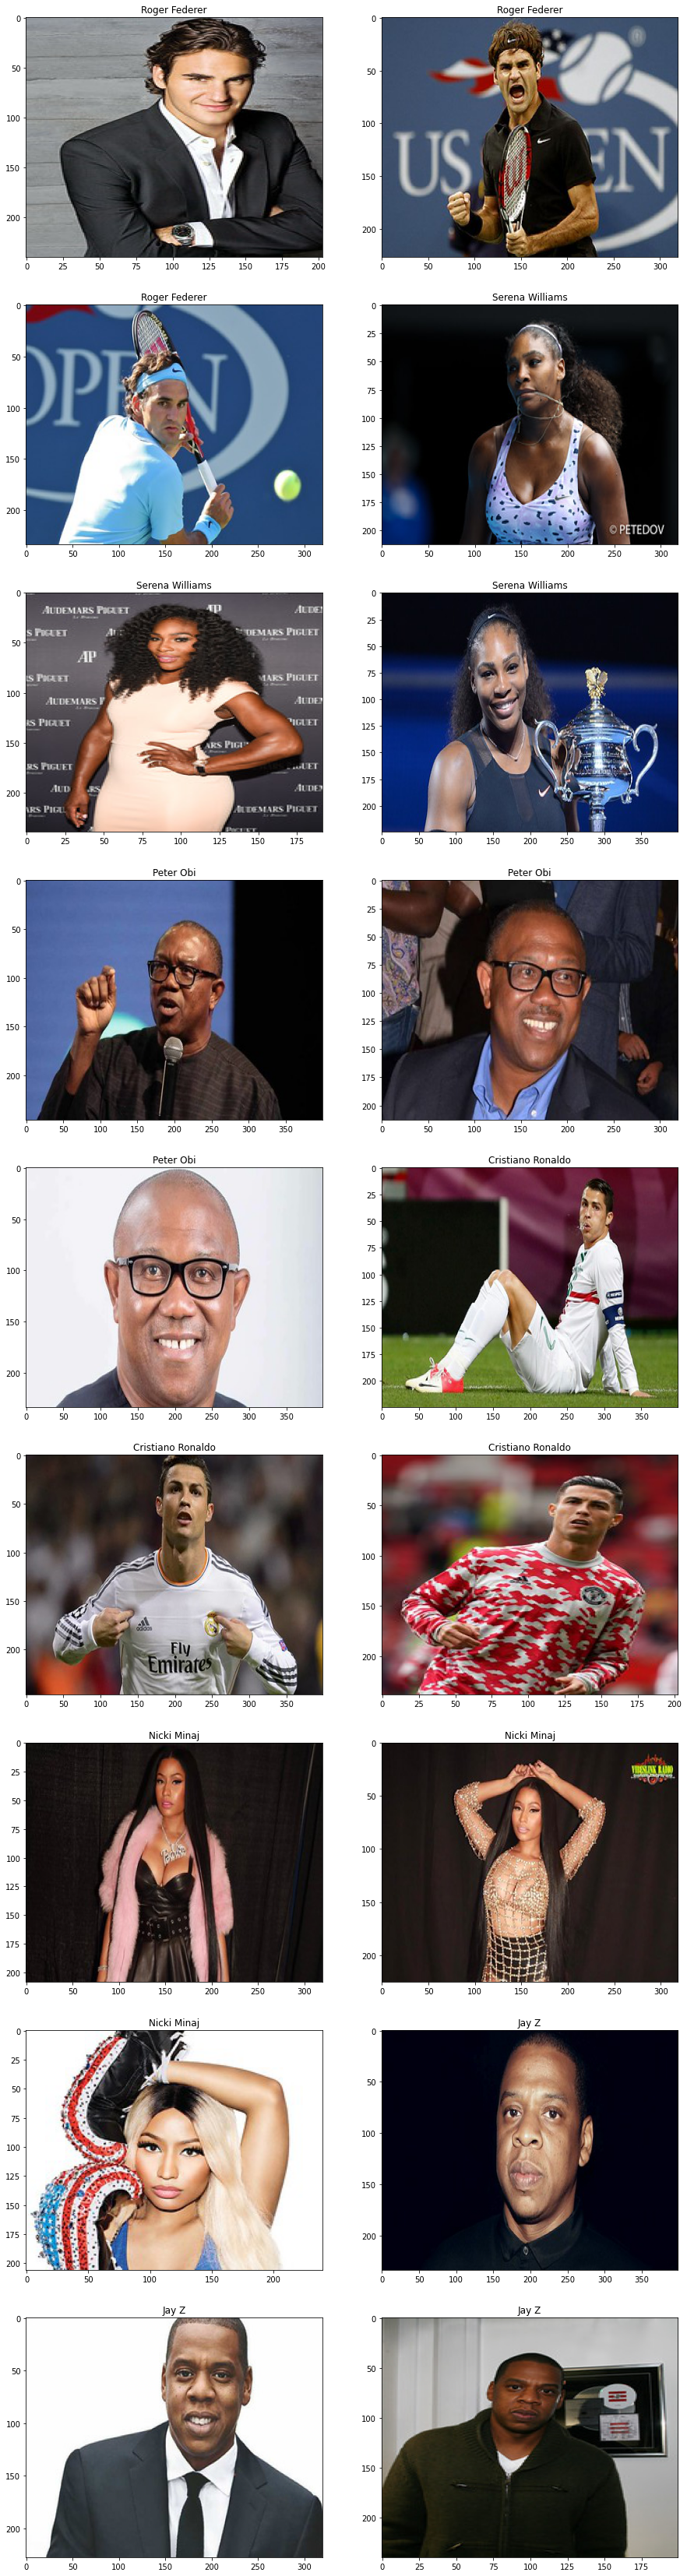

In [ ]:
from PIL import Image
from io import BytesIO
import requests
import os
import matplotlib.pyplot as plt

image_list = []
root_path = "celebrity_images/train"

def strip_invalid_filename_characters(filename) -> str:
    filename = filename.replace(" ", "_")
    return ("".join([char for char in filename if char.isalnum() or char in "._- "]))
plt.figure(figsize=(15, 60))
# Save the images into an organized directory structure
for index, (url, label) in enumerate(urls.items()):
  class_path = os.path.join(root_path, strip_invalid_filename_characters(label))
  os.makedirs(class_path, exist_ok=True)

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  filename = url.split("/")[-1]
  img.save(os.path.join(class_path, filename))

  plt.subplot(9, 2, index+1)
  plt.imshow(img, aspect='auto')
  plt.title(label)

  image_list.append(img)

Now, load this dataset using the `datasets` library using the `ImageFolder` dataset builder. You might find this reference useful: https://huggingface.co/docs/datasets/image_load#imagefolder

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir= root_path)

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-fd2c5d26efd32c6d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 18
})

Answer a few questions about the dataset you've built:

* Dataset size: How many images are in your dataset? How many different "labels" are there? [ANSWER HERE] 

* Dataset diversity: How what diversity / representativeness considerations did you take when building your dataset? [ANSWER HERE] 


* **Push the Dataset to the Hugging Face Hub**

Now that you have a dataset, upload it to the Hugging Face Hub so that you can share it with others! Here is some information about uploading datasets to the Hub: https://huggingface.co/docs/datasets/upload_dataset#upload-with-python


In [ ]:
dataset.push_to_hub("celeb-identities")

  0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Once you've uploaded your dataset, you should be able to preview the dataset, and see the number of samples and the labels of the each sample! 

What is the URL to your dataset: https://huggingface.co/datasets/capofwesh20/celeb-identities

Please make sure that the dataset is **public**

# Step 3: Evaluating the Embedding Models on your Dataset

Now, let's evaluate each of the models on the dataset you've built. For this example, we will evaluate how good the embeddings from the same celebrity. "cluster" together. 

So we now have to decide on a *metric* we will use to measure the performance for our machine learning models. There are many different metrics that allow you to assess the quality of clustering results. We will use the silhouette score (SS). This measure has a range of [-1, 1] and is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample. The SS for a _single sample_ is $(b - a) / \text{max}(a, b)$, where $b$ is the distance between a sample and the nearest cluster that the sample is not a part of.

![](https://uploads-ssl.webflow.com/5f5148a709e16c7d368ea080/5f7dea907b8e8c7769e769c8_5f7c9650bc3b1ed0ad2247eb_silhouette_formula.jpg)

We then take the average of value of the SS across all samples to get a single SS for our entire dataset.

In this case, we will be using the `sklearn.metrics.silhouette_score` function which takes in two required parameters: (1) a matrix consisting of the embeddings of a list of samples and (2) a list of labels. 

Using each of these three models:
* https://huggingface.co/sentence-transformers/clip-ViT-B-16
* https://huggingface.co/sentence-transformers/clip-ViT-B-32
* https://huggingface.co/sentence-transformers/clip-ViT-L-14

create embeddings for all of the training images of the celebrities. And then compute the SS metric for all of the embeddings. Also record the running time for computing the embeddings for each model.


In [ ]:
# Load all of the models 

models = [
    SentenceTransformer('clip-ViT-B-16'),
    SentenceTransformer('clip-ViT-L-14'),
    SentenceTransformer('clip-ViT-B-32')
]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [ ]:
import time
from sklearn.metrics import silhouette_score

model_log = []
for model in models:
  start_time = time.time()
  embedding = model.encode(dataset['train']['image'])
  stop_time = time.time()

  ss_score = silhouette_score(embedding, dataset['train']['label'])

  model_log.append({'model_name':model,
                    'runtime':stop_time-start_time,
                    'ss_score':ss_score})
  print({'model_name':model, 'runtime': stop_time-start_time, 'ss_score': ss_score})


{'model_name': SentenceTransformer(
  (0): CLIPModel()
), 'runtime': 0.6172780990600586, 'ss_score': 0.298519}
{'model_name': SentenceTransformer(
  (0): CLIPModel()
), 'runtime': 2.866626501083374, 'ss_score': 0.3100676}
{'model_name': SentenceTransformer(
  (0): CLIPModel()
), 'runtime': 0.5088980197906494, 'ss_score': 0.29851517}




* If you had to pick one model to use for facial identity recognition, which one would it be? Why? 

I will pick model 3 because it has the shortest runtime

# Step 4: Choosing a Distance Threshold

In order to use this model for facial identity recognition, we need to choose a _similarity threshold_. If two faces are similar enough to each other (above this threshold), we will quantify them as being from the same person. If they are below this threshold, we will quantify them as different. Using the model you identified in the previous part, let's first compute the average distance between each pair of embeddings, as well as the average distance between each pair of embeddings of images that belong to the same celebrity.

Again, we'll find *cosine_similarity* quite useful

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity



model = SentenceTransformer('clip-ViT-B-32')
embeddings = model.encode(dataset['train']['image'])

similarities = cosine_similarity(embeddings)
similarities

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


array([[0.99999976, 0.7996397 , 0.8130135 , 0.5633406 , 0.62580335,
        0.5018843 , 0.54934394, 0.5163145 , 0.5000587 , 0.4804045 ,
        0.48632565, 0.42678618, 0.64610064, 0.58184326, 0.50760865,
        0.38004103, 0.6061429 , 0.54092836],
       [0.7996397 , 0.9999995 , 0.79547083, 0.54827297, 0.5299643 ,
        0.5130316 , 0.49963868, 0.50667113, 0.5007762 , 0.419088  ,
        0.4376643 , 0.41895428, 0.6481439 , 0.5864247 , 0.4995667 ,
        0.4230123 , 0.5230456 , 0.5228513 ],
       [0.8130135 , 0.79547083, 0.9999999 , 0.51529825, 0.54634595,
        0.47520104, 0.49079192, 0.4674557 , 0.46941042, 0.44684476,
        0.44974247, 0.42642227, 0.6345328 , 0.61303234, 0.5029402 ,
        0.3791129 , 0.5171324 , 0.5094934 ],
       [0.5633406 , 0.54827297, 0.51529825, 1.0000001 , 0.893987  ,
        0.87306726, 0.6212219 , 0.6363123 , 0.6627582 , 0.48137784,
        0.5331558 , 0.53632873, 0.5268666 , 0.44912916, 0.52551305,
        0.5612458 , 0.50011045, 0.47829378],
    

* What is the average cosine similarity between **all images**?

In [ ]:
import numpy as np

np.mean(similarities)

0.5540537

* What is the average cosine similarity between all images of the **same celebrity**?

In [ ]:
import numpy as np

for i in range(0, 18, 3):
  j = i + 3
  a = np.mean(similarities[i:j, i:j])

  print(np.mean(a))

0.86847186
0.91302365
0.9261585
0.85680455
0.7898744
0.8011558


Based on the above calculations, what similarity threshold do you pick, and why? 0.78

# Step 5: Building a Demo

A high-level metric like accuracy doesn't give us a great idea on how the model will work when presented with new data from the real world. To understand this, we will build a web-based demo that can be used on our phones or computers through a web browser to test our model.

The `gradio` library lets you build web demos of machine learning models with just a few lines code. Learn more about Gradio here: https://gradio.app/getting_started/

Gradio lets you build machine learning demos simply by specifying (1) a prediction function, (2) the input type and (3) the output type of your model. Write a prediction function that takes in two images and returns "SAME PERSON, UNLOCK PHONE" if they are within the distance threshold and "DIFFERENT PEOPLE, DON'T UNLOCK" if they are above the distance threshold 

In [ ]:
import matplotlib.pyplot as plt

def predict(im1, im2):
  embeding = model.encode([im1, im2])
  sim = cosine_similarity(embeding)
  sim = sim[0][1]
  if sim > 0.78: # THRESHOLD HERE
    return sim, "SAME PERSON, UNLOCK PHONE"
  else:
    return sim, "DIFFERENT PEOPLE, DON'T UNLOCK"


    

* **Build a Gradio web demo of your image classifier and `launch()` it**

Create a `gradio.Interface` and launch it! In this case, we've provided the Gradio code that you need to launch the demo.

In [ ]:
import gradio as gr


title = 'Face ID'
description = 'This model detects the similarity between two images and passes a command!'


article = """
            Upload and Image from your Device or Make use of your webcam 
          """

img_upload = gr.Interface(
    fn=predict, 
    inputs= [gr.Image(type="pil", source="upload"), 
             gr.Image(type="pil", source="upload")], 
    outputs= [gr.Number(label="Similarity"),
              gr.Textbox(label="Message")],
    title=title,
    description=description,
    article=article
    )

webcam_upload = gr.Interface(
    fn=predict, 
    inputs= [gr.Image(type="pil", source="webcam"), 
            gr.Image(type="pil", source="webcam")], 
    outputs= [gr.Number(label="Similarity"),
              gr.Textbox(label="Message")],
    title=title,
    description=description,
    article=article,
    )

face_id = gr.TabbedInterface(
    [img_upload, webcam_upload], 
    ["Upload-Image", "Use Webcam"])

face_id.launch(debug=True)






/usr/local/lib/python3.7/dist-packages/gradio/blocks.py:658: UserWarning: api_name predict already exists, using predict_1
  api_name, api_name_


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://22298.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f63bb923c50>,
 'http://127.0.0.1:7860/',
 'https://22298.gradio.app')

# Step 6: Trying your Model with "Real World" Data!

* **Use the share link created above to open up your app on your phone**

Now test your model on some real images -- of yourself or your friends. What do you notice about the performance of your model on your own images versus those on the training set?  

The model performs ok on unseen data